In [106]:
import logging
import os
import re
from typing import Optional, List

import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler, BatchSampler
from torchvision.transforms import ColorJitter, Normalize, RandomHorizontalFlip, RandomVerticalFlip, RandomAdjustSharpness
from timm import create_model
from einops import rearrange, reduce
from skimage.color import label2rgb
from skimage.measure import regionprops_table

In [2]:
from deep_spatial_genomics.models.x_unet import XUnet

#### train/val data

In [3]:
train_adata = sc.read_h5ad('/storage1/fs1/dinglab/Active/Projects/Datasets/spatial_transcriptomics/st_tme_tool_development/brca/HT397B1-S1H2A4/adata.h5ad')
train_adata.X = train_adata.layers['counts'] # using raw counts
train_adata = train_adata[:, train_adata.var['highly_variable']]
train_adata

View of AnnData object with n_obs × n_vars = 3561 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'clusters', 'alla_label', 'spot_index'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'alla_label_colors', 'full_res_he', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'rescaled_he', 'rescaled_spot_masks', 'rescaled_spot_metadata', 'spatial', 'trimmed', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_16X_notrim', 'spatial_16X_trimmed', 'spatial_1X_notrim', 'spatial_1X_trimmed', 'spatial_2X_notrim', 'spatial_2X_trimmed', 'spatial_4X_notrim', 'spatial_4X_trimmed', 'spatial_8X_notrim', 'spatial_8X_trimmed', 'spatial_trimmed'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [4]:
val_adata = sc.read_h5ad('/storage1/fs1/dinglab/Active/Projects/Datasets/spatial_transcriptomics/st_tme_tool_development/brca/HT397B1-S1H3A1/adata.h5ad')
val_adata.X = val_adata.layers['counts'] # using raw counts
val_adata = val_adata[:, train_adata.var.index]
val_adata

View of AnnData object with n_obs × n_vars = 3494 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'clusters', 'spot_index'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'full_res_he', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'rescaled_he', 'rescaled_spot_masks', 'rescaled_spot_metadata', 'spatial', 'trimmed', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_16X_notrim', 'spatial_16X_trimmed', 'spatial_1X_notrim', 'spatial_1X_trimmed', 'spatial_2X_notrim', 'spatial_2X_trimmed', 'spatial_4X_notrim', 'spatial_4X_trimmed', 'spatial_8X_notrim', 'spatial_8X_trimmed', 'spatial_trimmed'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

#### preprocessing

Instead of tiling the data and training on non-overlapping patches, we sample patch coordinates uniformly random from the section surfaces and extract patches directly from the dataset during learning. Patches are distorted with uniformly sampled rotations from (0∘, 360∘), scaling from (0.95, 1.05) and shearing from (0∘, 10∘). The image data are further distorted with random brightness, contrast, saturation and hue jitter independently sampled from (−5%, 5%).

In [5]:
class HETransform(object):
    def __init__(self, p=.8, brightness=.1, contrast=.1, saturation=.1, hue=.1, sharpness=.3):
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.hue = hue
        self.sharpness = sharpness
        
        self.normalize = Normalize((0.771, 0.651, 0.752), (0.229, 0.288, 0.224)) # from HT397B1-H2 ffpe H&E image
 
        self.p = p
    
    def apply_color_transforms(self, x, brightness, contrast, saturation, hue, sharpness):
        x = TF.adjust_brightness(x, brightness)
        x = TF.adjust_contrast(x, contrast)
        x = TF.adjust_saturation(x, saturation)
        x = TF.adjust_hue(x, hue)
        x = TF.adjust_sharpness(x, sharpness)
        return x
        
    def __call__(self, he, mask):
        """
        """
        if isinstance(he, torch.Tensor):
            hes = [he]
            masks = [mask]
            return_type = 'image'
        elif isinstance(he, dict):
            keys = list(he.keys())
            hes = [he[k] for k in keys]
            masks = [mask[k] for k in keys]
            return_type = 'dict'
        else:
            return_type = 'list'
                                
        # we apply transforms with probability p
        if torch.rand(size=(1,)) < self.p:
            brightness, contrast, saturation, hue, sharpness = (
                np.random.uniform(max(0, 1 - self.brightness), 1 + self.brightness, size=1)[0],
                np.random.uniform(max(0, 1 - self.contrast), 1 + self.contrast, size=1)[0],
                np.random.uniform(max(0, 1 - self.saturation), 1 + self.saturation, size=1)[0],
                np.random.uniform(-self.hue, self.hue, size=1)[0],
                np.random.uniform(max(0, 1 - self.sharpness), 1 + self.sharpness, size=1)[0],
            )
            # apply color jitter and sharpness
            hes = [self.apply_color_transforms(x, brightness, contrast, saturation, hue, sharpness)
                   for x in hes]
            
            # vertical and horizontal flips happen with p=.5
            do_hflip, do_vflip = torch.rand(size=(2,)) < .5 
            if do_hflip:
                hes = [TF.hflip(x) for x in hes]
                masks = [TF.hflip(x) for x in masks]
            if do_vflip:
                hes = [TF.vflip(x) for x in hes]
                masks = [TF.vflip(x) for x in masks]
        
        # normalize he
        hes = [self.normalize(x) for x in hes]
                    
        if return_type == 'image':
            return hes[0], masks[0]
        elif return_type == 'dict':
            return {k:v for k, v in zip(keys, hes)}, {k:v for k, v in zip(keys, masks)}
        return hes, masks

In [6]:
def convert_rgb(img):
    if img.shape[-1] == 3:
        img = rearrange(img, 'h w c -> c h w')
        
    if not isinstance(img, torch.Tensor):
        img = torch.Tensor(img)
        
    if torch.max(img)>1.1:
        img = TF.convert_image_dtype(img, dtype=torch.float32) / 255.
            
    return img


def generate_voxel_masks(labeled_mask, padded_spot_idxs, n_voxels):
    masks = torch.zeros((padded_spot_idxs.shape[0], labeled_mask.shape[0], labeled_mask.shape[1]))
    for i, l in enumerate(padded_spot_idxs[:n_voxels]):
        m = labeled_mask.clone().detach()
        m[m!=l] = 0.
        m[m==l] = 1.
        masks[i] = m
    return masks


class STDataset(Dataset):
    """ST Dataset"""
    def __init__(self, adata, he_dict, mask_dict, coordinate_key,
                 tile_sizes=512, use_raw=False, he_transform=None,
                 border=512, max_jitter=0., sample_multiplier=1):
        """
        adata: AnnData object
            - .X must be unnormalized counts
            - must have column in .obs['spot_index'] that specified the spot index in the scaled mask dict
        scaled_he_dict: dict
            - values are rgb H&E images, keys are '[0-9]+X', where the integer in front of X is the scale factor of the H&E image.
        scaled_mask_dict: dict
            - values are labeled images where 0 is background and all other pixels coorespond to index stored in .obs['spot_index'].
        """
        super().__init__()
        # make sure we are ordered by spot index
        self.spot_ids, _ = zip(*sorted([(sid, sidx) for sid, sidx in zip(adata.obs.index, adata.obs['spot_index'])],
                                    key=lambda x: x[1]))
        self.spot_ids = np.asarray(self.spot_ids)
        self.adata = adata[self.spot_ids]
        self.he_dict = {k:convert_rgb(v) for k, v in he_dict.items()}
        self.mask_dict = {k:torch.Tensor(v).to(torch.int32) if not isinstance(v, torch.Tensor) else v
                                 for k, v in mask_dict.items()}
        self.scales = sorted([int(re.sub(r'^([0-9]+)X$', r'\1', k)) for k in self.he_dict.keys()])
        
        if isinstance(tile_sizes, int):
            self.tile_sizes = [tile_sizes] * len(self.scales)
        else:
            self.tile_sizes = tile_sizes # defines the size of crops to be taken from each h&e resolution
        
        _, n_row, n_col = self.he_dict[str(self.scales[0]) + 'X'].shape
        self.offset = int(self.tile_sizes[0] // 2 + 1)
        self.border = border
  
        self.pixel_coords = np.asarray(
            [[int(r + np.random.uniform(-max_jitter, max_jitter)),
              int(c + np.random.uniform(-max_jitter, max_jitter))]
             for c, r in self.adata.obsm[coordinate_key]])
        if sample_multiplier > 1:
            for i in range(sample_multiplier - 1):
                self.pixel_coords = np.concatenate(
                    (self.pixel_coords,
                     np.asarray(
                        [[int(r + np.random.uniform(-max_jitter, max_jitter)),
                          int(c + np.random.uniform(-max_jitter, max_jitter))]
                         for c, r in self.adata.obsm[coordinate_key]])), axis=0)
        
        self.he_transform = he_transform
        
        
        # expression related
        self.use_raw = use_raw
        
        idxs = np.random.choice(np.arange(self.pixel_coords.shape[0]), size=1000)
        key = str(self.scales[0]) + 'X'
        max_spots = 0
        for i in idxs:
            mask = self.mask_dict[key]
            r, c = self.pixel_coords[i]
            r, c = r + self.border, c + self.border # adjust for reflection padding
            r, c = r - self.offset, c - self.offset # adjust from center to top left
            m = TF.crop(mask, top=r, left=c, height=self.tile_sizes[0], width=self.tile_sizes[0])
            max_spots = max(max_spots, len(np.unique(m)))
        self.max_spots = 2**int(np.log2(max_spots) + 1)

    def __len__(self):
        return len(self.pixel_coords)

    def __getitem__(self, idx):
        r, c = self.pixel_coords[idx]
        initial = self.scales[0]
        scale_to_coords = {s: (
                               int((r / (s / initial)) - self.offset + self.border),
                               int((c / (s / initial)) - self.offset + self.border)
                           )
                           for i, s in enumerate(self.scales)}
        he_tile_dict, mask_tile_dict = {}, {}
        for scale, tile_size in zip(self.scales, self.tile_sizes):
            key = f'{scale}X'
            he, mask = self.he_dict[key], self.mask_dict[key]
            r, c = scale_to_coords[scale]
            he_tile_dict[key] = TF.crop(he, top=r, left=c, height=tile_size, width=tile_size)
            mask_tile_dict[key] = TF.crop(mask, top=r, left=c, height=tile_size, width=tile_size)

        if self.he_transform is not None:
            he_tile_dict, mask_tile_dict = self.he_transform(he_tile_dict, mask_tile_dict)
        spot_idxs = torch.unique(mask_tile_dict[str(self.scales[0]) + 'X']).numpy() - 1
        spot_idxs = spot_idxs[1:] # drop first value, which is background
        
        if self.use_raw:
            x = self.adata.raw.X[spot_idxs]
        else:
            x = self.adata.X[spot_idxs]
        
        if 'sparse' in str(type(x)).lower():
            x = x.toarray()
            
        padded_exp = torch.zeros((self.max_spots, x.shape[1]))
        padded_exp[:x.shape[0]] = torch.Tensor(x)
        
        padded_spot_idxs = np.asarray([0] * self.max_spots)
        padded_spot_idxs[:spot_idxs.shape[0]] = spot_idxs + 1
        
        masks = generate_voxel_masks(mask_tile_dict[str(self.scales[0]) + 'X'],
                                     padded_spot_idxs, x.shape[0])
                
        return {
            'X': padded_exp,
            'he_tiles': he_tile_dict,
            'mask_tiles': mask_tile_dict,
            'voxel_idxs': padded_spot_idxs,
            'masks': masks,
            'n_voxels': x.shape[0],
            'b': torch.Tensor([1.]) # just make everything the same batch for now
        }

In [7]:
train_adata

View of AnnData object with n_obs × n_vars = 3561 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'clusters', 'alla_label', 'spot_index'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'alla_label_colors', 'full_res_he', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'rescaled_he', 'rescaled_spot_masks', 'rescaled_spot_metadata', 'spatial', 'trimmed', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_16X_notrim', 'spatial_16X_trimmed', 'spatial_1X_notrim', 'spatial_1X_trimmed', 'spatial_2X_notrim', 'spatial_2X_trimmed', 'spatial_4X_notrim', 'spatial_4X_trimmed', 'spatial_8X_notrim', 'spatial_8X_trimmed', 'spatial_trimmed'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [8]:
def reflection_mosiac(x, border=256, dtype=torch.int32):
    max_r, max_c = x.shape[-2], x.shape[-1]
    if len(x.shape) == 3:
        mosaic = torch.zeros((x.shape[0], max_r + (border * 2), max_c + (border * 2))).to(dtype)
    else:
        mosaic = torch.zeros((max_r + (border * 2), max_c + (border * 2))).to(dtype)
    
    # make tiles
    top_left = TF.pad(x, padding=[border, border, 0, 0], padding_mode='reflect')
    top_right = TF.pad(x, padding=[0, border, border, 0], padding_mode='reflect')
    bottom_left = TF.pad(x, padding=[border, 0, 0, border], padding_mode='reflect')
    bottom_right = TF.pad(x, padding=[0, 0, border, border], padding_mode='reflect')
    
    if len(x.shape) == 3:
        mosaic[:, :max_r + border, :max_c + border] = top_left
        mosaic[:, :max_r + border, border:] = top_right
        mosaic[:, border:, :max_c + border] = bottom_left
        mosaic[:, border:, border:] = bottom_right
    else:
        mosaic[:max_r + border, :max_c + border] = top_left
        mosaic[:max_r + border, border:] = top_right
        mosaic[border:, :max_c + border] = bottom_left
        mosaic[border:, border:] = bottom_right
    
    return mosaic

In [9]:
def get_img_dicts(adata, keys=('2X', '8X'), border=256):
    he_dict = {}
    for k, x in adata.uns['rescaled_he'].items():
        if re.findall(r'^[0-9]+X.*$', k) and 'trimmed' in k:
            scale = int(re.sub(r'^([0-9]+)X.*$', r'\1', k))
            x = torch.Tensor(rearrange(x, 'h w c -> c h w')).to(torch.uint8)
            x = reflection_mosiac(x, border=border, dtype=torch.uint8)
            x = rearrange(x, 'c h w -> h w c').numpy().astype(np.uint8)
            he_dict[f'{scale}X'] = x
            
    mask_dict = {}
    for k, x in adata.uns['rescaled_spot_masks'].items():
        if re.findall(r'^[0-9]+X.*$', k) and 'trimmed' in k:
            scale = int(re.sub(r'^([0-9]+)X.*$', r'\1', k))
            x = torch.Tensor(x.astype(np.int32))
            x = reflection_mosiac(x, border=border, dtype=torch.int32)
            x = x.numpy().astype(np.int32)
            mask_dict[f'{scale}X'] = x
            
    he_dict = {k:v for k, v in he_dict.items() if k in keys}
    mask_dict = {k:v for k, v in mask_dict.items() if k in keys}
    
    return he_dict, mask_dict

In [10]:
keys = ['2X', '8X']
tile_size = 256
spot_radius = train_adata.uns['rescaled_spot_metadata'][keys[0] + '_trimmed']['spot_radius']
jitter = spot_radius * 2
border = jitter * 2

he_dict, mask_dict = get_img_dicts(train_adata, keys=keys, border=border)

train_he_transform = HETransform(p=.8, brightness=.05, contrast=.05, saturation=.05, hue=.05)
train_ds = STDataset(train_adata, he_dict, mask_dict,
                     tile_sizes=tile_size, he_transform=train_he_transform,
                     max_jitter=jitter, border=border,
                     coordinate_key='spatial_2X_trimmed', sample_multiplier=100)

In [11]:
he_dict, mask_dict = get_img_dicts(val_adata, keys=keys, border=border)

val_he_transform = HETransform(p=0.)
val_ds = STDataset(val_adata, he_dict, mask_dict,
                   tile_sizes=tile_size, he_transform=val_he_transform,
                   max_jitter=0., border=border,
                   coordinate_key='spatial_2X_trimmed', sample_multiplier=1)

In [12]:
batch_size = 64

In [13]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, pin_memory=True)

In [14]:
# b = next(iter(train_dl))

###### input data sanity check

In [470]:
len(train_ds), len(val_ds)

(356100, 3494)

In [471]:
train_ds.pixel_coords

array([[6469, 2995],
       [1314, 2025],
       [5861, 6939],
       ...,
       [2710, 2149],
       [1990, 1892],
       [2639,  488]])

In [472]:
%%time
d = train_ds[4444]
d.keys()

CPU times: user 1.33 s, sys: 5.26 ms, total: 1.34 s
Wall time: 43.1 ms


dict_keys(['X', 'he_tiles', 'mask_tiles', 'voxel_idxs', 'masks', 'n_voxels', 'b'])

In [473]:
d['X'].shape, d['voxel_idxs'].shape, d['masks'].shape, d['n_voxels']

(torch.Size([16, 17943]), (16,), torch.Size([16, 256, 256]), 6)

In [474]:
d['voxel_idxs']

array([ 640,  884, 1595, 1619, 1955, 2316,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0])

In [475]:
train_adata.obs.iloc[d['voxel_idxs'][:d['n_voxels']] - 1]

in_tissue  array_row  array_col clusters alla_label  \
AGTCGTATAAAGCAGA-1          1         65         81        4        NaN   
ATTGCCTTTATGTTTG-1          1         64         84        4        NaN   
CTAGTAGAAAGGGATT-1          1         63         81       10        NaN   
CTCAACTAACCCGGAT-1          1         63         85        0        NaN   
GAGTGTCAACCAGAAA-1          1         63         83        2        NaN   
GGCGTAGGGAAAGCTG-1          1         64         82        2        NaN   

                    spot_index highlight  
AGTCGTATAAAGCAGA-1         640       yes  
ATTGCCTTTATGTTTG-1         884       yes  
CTAGTAGAAAGGGATT-1        1595       yes  
CTCAACTAACCCGGAT-1        1619       yes  
GAGTGTCAACCAGAAA-1        1955       yes  
GGCGTAGGGAAAGCTG-1        2316       yes

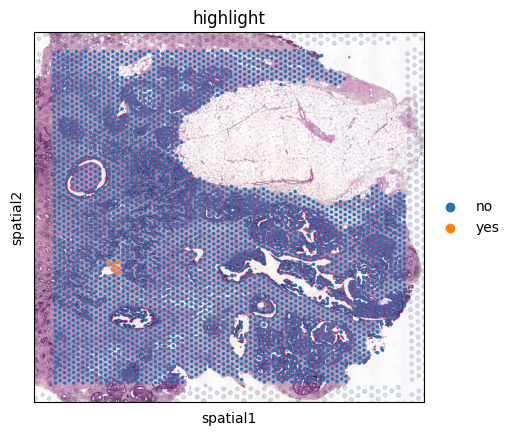

In [476]:
train_adata.obs['highlight'] = ['yes' if i in d['voxel_idxs'][:d['n_voxels']] else 'no'
                               for i in train_adata.obs['spot_index']]
sc.pl.spatial(train_adata, color='highlight')

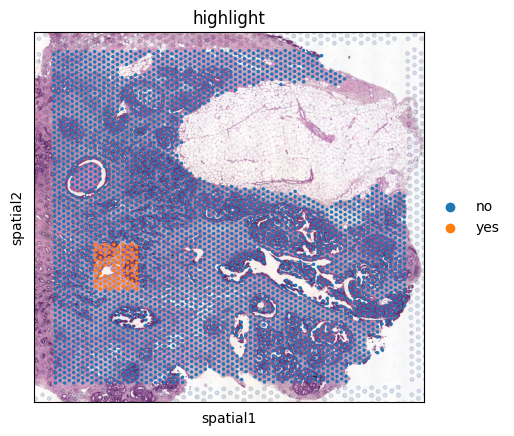

In [477]:
train_adata.obs['highlight'] = ['yes' if i in np.unique(d['mask_tiles']['8X']) else 'no'
                               for i in train_adata.obs['spot_index']]
sc.pl.spatial(train_adata, color='highlight')

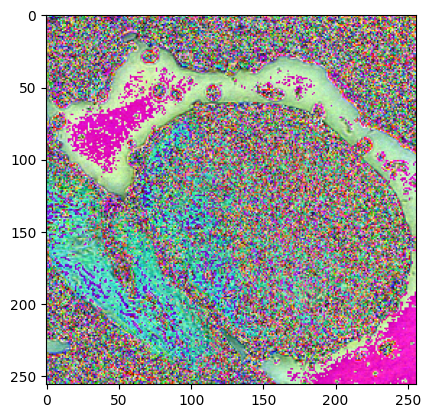

In [478]:
tile = rearrange(TF.convert_image_dtype(d['he_tiles']['2X'], torch.uint8), 'c h w -> h w c')
plt.imshow(tile)

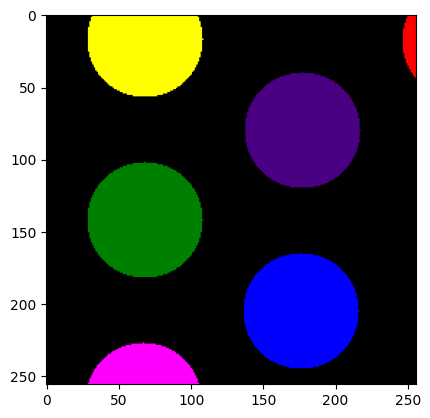

In [479]:
tile = label2rgb(d['mask_tiles']['2X'].numpy())
plt.imshow(tile)

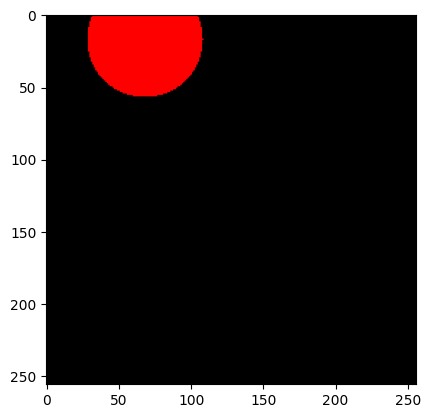

In [480]:
tile = label2rgb(d['masks'][2].numpy())
plt.imshow(tile)

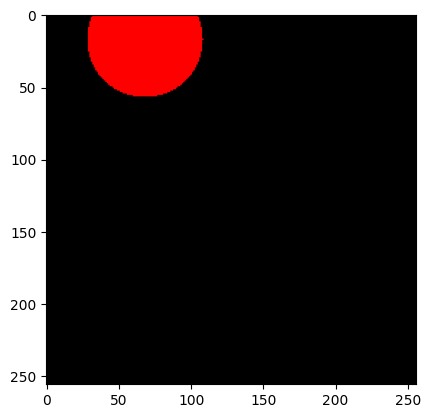

In [481]:
tile = label2rgb(d['mask_tiles']['2X'].numpy()==d['voxel_idxs'][2])
plt.imshow(tile)

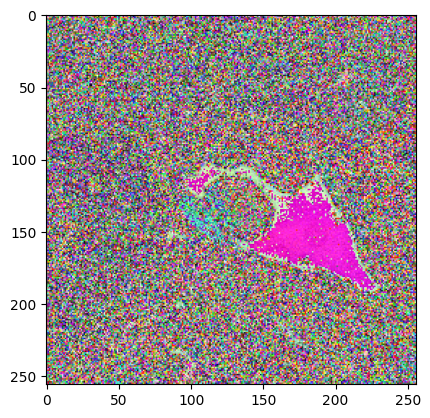

In [482]:
tile = rearrange(TF.convert_image_dtype(d['he_tiles']['8X'], torch.uint8), 'c h w -> h w c')
plt.imshow(tile)

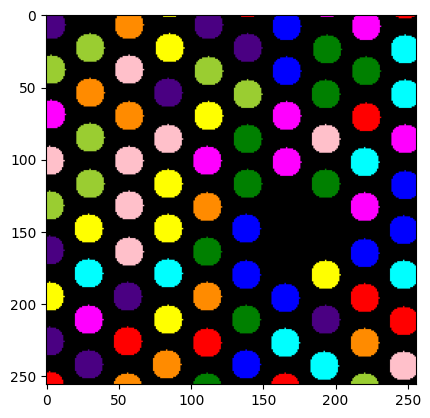

In [483]:
tile = label2rgb(d['mask_tiles']['8X'].numpy())
plt.imshow(tile)

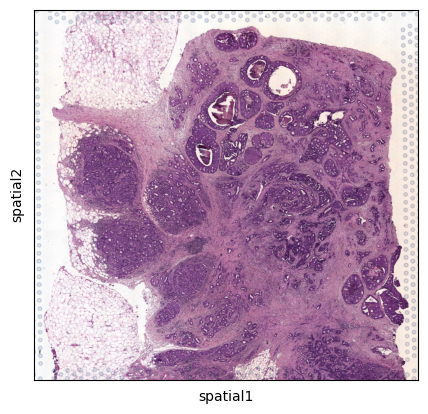

In [484]:
sc.pl.spatial(val_adata)

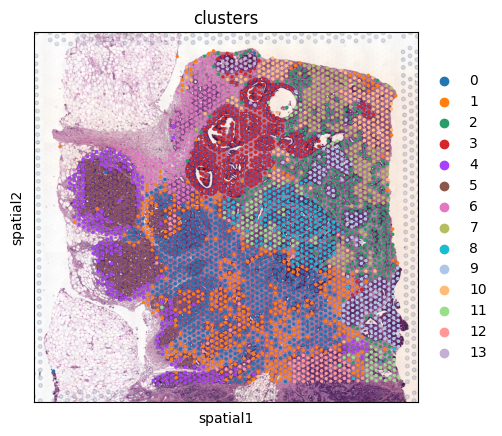

In [485]:
sc.pl.spatial(val_adata, color='clusters')

In [486]:
d = val_ds[200]
d.keys()

dict_keys(['X', 'he_tiles', 'mask_tiles', 'voxel_idxs', 'masks', 'n_voxels', 'b'])

In [487]:
d['X'].shape, d['voxel_idxs'].shape, d['masks'].shape, d['n_voxels']

(torch.Size([16, 17943]), (16,), torch.Size([16, 256, 256]), 6)

In [488]:
d['voxel_idxs']

array([ 201, 1137, 1495, 2435, 3237, 3315,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0])

In [489]:
val_ds.pixel_coords

array([[6376, 2827],
       [2667, 7849],
       [5838, 6700],
       ...,
       [2671, 1924],
       [1727, 3314],
       [3167, 7424]])

In [490]:
val_adata.obs.iloc[d['voxel_idxs'][:d['n_voxels']] - 1]

in_tissue  array_row  array_col clusters  spot_index  \
AATGGTCCACCGTTCA-1          1         30         16        3         201   
CCAGCTTCCGCCCGCA-1          1         29         17        3        1137   
CGTCAAGGCTATAAAT-1          1         30         14        3        1495   
GTCATTGCATTGACCC-1          1         31         17        3        2435   
TGTCCGTGGCGCCTTT-1          1         30         18        3        3237   
TTAGCTCTGTAATCCG-1          1         31         15        3        3315   

                   highlight  
AATGGTCCACCGTTCA-1        no  
CCAGCTTCCGCCCGCA-1        no  
CGTCAAGGCTATAAAT-1       yes  
GTCATTGCATTGACCC-1        no  
TGTCCGTGGCGCCTTT-1        no  
TTAGCTCTGTAATCCG-1        no

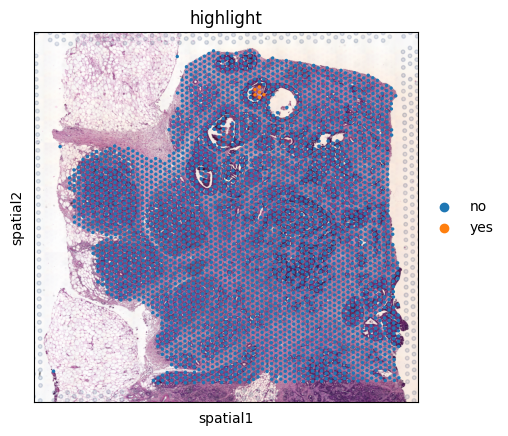

In [491]:
val_adata.obs['highlight'] = ['yes' if i in d['voxel_idxs'][:d['n_voxels']] else 'no'
                               for i in val_adata.obs['spot_index']]
sc.pl.spatial(val_adata, color='highlight')

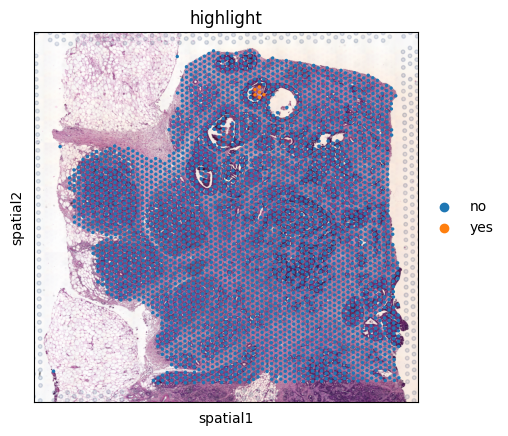

In [492]:
val_adata.obs['highlight'] = ['yes' if i in np.unique(d['mask_tiles']['2X']) else 'no'
                               for i in val_adata.obs['spot_index']]
sc.pl.spatial(val_adata, color='highlight')

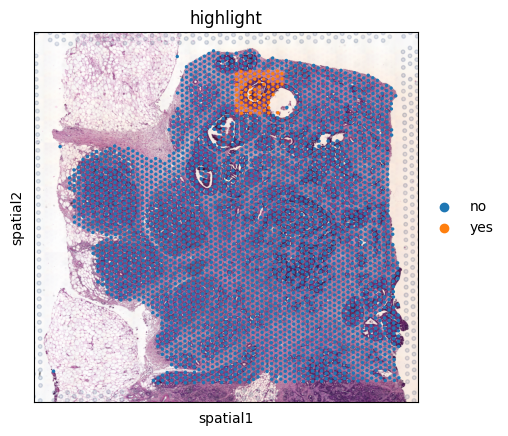

In [493]:
val_adata.obs['highlight'] = ['yes' if i in np.unique(d['mask_tiles']['8X']) else 'no'
                               for i in val_adata.obs['spot_index']]
sc.pl.spatial(val_adata, color='highlight')

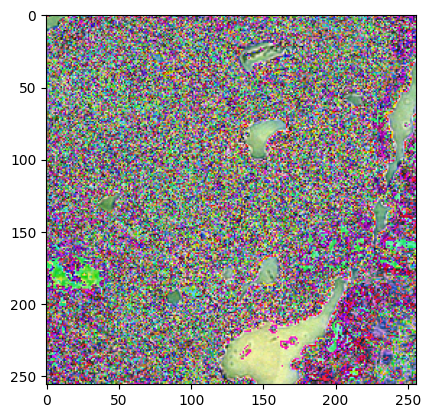

In [494]:
tile = rearrange(TF.convert_image_dtype(d['he_tiles']['2X'], torch.uint8), 'c h w -> h w c')
plt.imshow(tile)

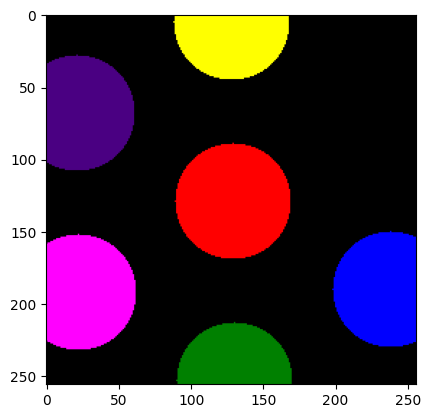

In [495]:
tile = label2rgb(d['mask_tiles']['2X'].numpy())
plt.imshow(tile)

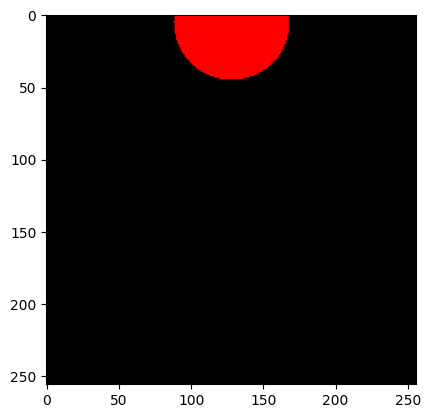

In [496]:
tile = label2rgb(d['masks'][2].numpy())
plt.imshow(tile)

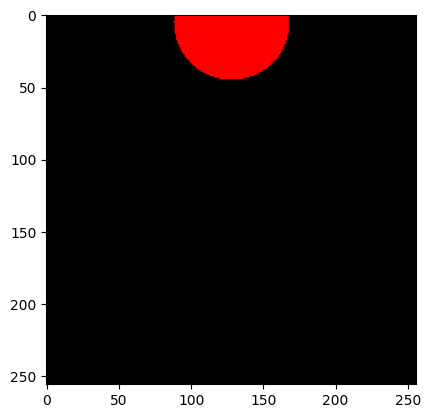

In [497]:
tile = label2rgb(d['mask_tiles']['2X'].numpy()==d['voxel_idxs'][2])
plt.imshow(tile)

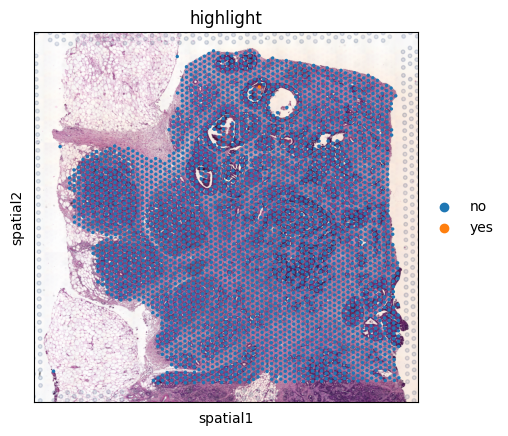

In [498]:
val_adata.obs['highlight'] = ['yes' if i == d['voxel_idxs'][2] else 'no'
                               for i in val_adata.obs['spot_index']]
sc.pl.spatial(val_adata, color='highlight')

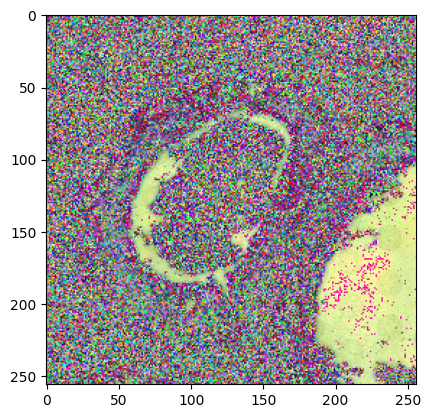

In [499]:
tile = rearrange(TF.convert_image_dtype(d['he_tiles']['8X'], torch.uint8), 'c h w -> h w c')
plt.imshow(tile)

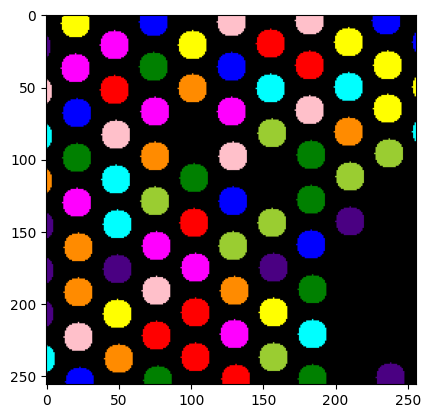

In [500]:
tile = label2rgb(d['mask_tiles']['8X'].numpy())
plt.imshow(tile)

#### model

In [15]:
"""
modified from https://gist.github.com/rwightman/f8b24f4e6f5504aba03e999e02460d31
"""
class Unet(nn.Module):
    """Unet is a fully convolution neural network for image semantic segmentation
    Args:
        encoder_name: name of classification model (without last dense layers) used as feature
            extractor to build segmentation model.
        encoder_weights: one of ``None`` (random initialization), ``imagenet`` (pre-training on ImageNet).
        decoder_channels: list of numbers of ``Conv2D`` layer filters in decoder blocks
        decoder_use_batchnorm: if ``True``, ``BatchNormalisation`` layer between ``Conv2D`` and ``Activation`` layers
            is used.
        num_classes: a number of classes for output (output shape - ``(batch, classes, h, w)``).
        center: if ``True`` add ``Conv2dReLU`` block on encoder head
    NOTE: This is based off an old version of Unet in https://github.com/qubvel/segmentation_models.pytorch
    """

    def __init__(
            self,
            backbone='resnet34',
            backbone_kwargs=None,
            backbone_indices=None,
            decoder_use_batchnorm=True,
            decoder_channels=(256, 128, 64, 32, 16),
            in_chans=1,
            num_classes=5,
            center=False,
            norm_layer=nn.BatchNorm2d,
    ):
        super().__init__()
        backbone_kwargs = backbone_kwargs or {}
        # NOTE some models need different backbone indices specified based on the alignment of features
        # and some models won't have a full enough range of feature strides to work properly.
        encoder = create_model(
            backbone, features_only=True, out_indices=backbone_indices, in_chans=in_chans,
            pretrained=False, **backbone_kwargs)
        encoder_channels = encoder.feature_info.channels()[::-1]
        self.encoder = encoder

        if not decoder_use_batchnorm:
            norm_layer = None
        self.decoder = UnetDecoder(
            encoder_channels=encoder_channels,
            decoder_channels=decoder_channels,
            final_channels=num_classes,
            norm_layer=norm_layer,
            center=center,
        )

    def forward(self, x: torch.Tensor):
        x = self.encoder(x)
        x.reverse()  # torchscript doesn't work with [::-1]
        x = self.decoder(x)
        return x


class Conv2dBnAct(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0,
                 stride=1, act_layer=nn.ReLU, norm_layer=nn.BatchNorm2d):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False)
        self.bn = norm_layer(out_channels)
        self.act = act_layer(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, scale_factor=2.0, act_layer=nn.ReLU, norm_layer=nn.BatchNorm2d):
        super().__init__()
        conv_args = dict(kernel_size=3, padding=1, act_layer=act_layer)
        self.scale_factor = scale_factor
        if norm_layer is None:
            self.conv1 = Conv2dBnAct(in_channels, out_channels, **conv_args)
            self.conv2 = Conv2dBnAct(out_channels, out_channels,  **conv_args)
        else:
            self.conv1 = Conv2dBnAct(in_channels, out_channels, norm_layer=norm_layer, **conv_args)
            self.conv2 = Conv2dBnAct(out_channels, out_channels, norm_layer=norm_layer, **conv_args)

    def forward(self, x, skip: Optional[torch.Tensor] = None):
        if self.scale_factor != 1.0:
            x = F.interpolate(x, scale_factor=self.scale_factor, mode='nearest')
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class UnetDecoder(nn.Module):

    def __init__(
            self,
            encoder_channels,
            decoder_channels=(256, 128, 64, 32, 16),
            final_channels=1,
            norm_layer=nn.BatchNorm2d,
            center=False,
    ):
        super().__init__()

        if center:
            channels = encoder_channels[0]
            self.center = DecoderBlock(channels, channels, scale_factor=1.0, norm_layer=norm_layer)
        else:
            self.center = nn.Identity()

        in_channels = [in_chs + skip_chs for in_chs, skip_chs in zip(
            [encoder_channels[0]] + list(decoder_channels[:-1]),
            list(encoder_channels[1:]) + [0])]
        out_channels = decoder_channels

        self.blocks = nn.ModuleList()
        for in_chs, out_chs in zip(in_channels, out_channels):
            self.blocks.append(DecoderBlock(in_chs, out_chs, norm_layer=norm_layer))
        self.final_conv = nn.Conv2d(out_channels[-1], final_channels, kernel_size=(1, 1))

        self._init_weight()

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x: List[torch.Tensor]):
        encoder_head = x[0]
        skips = x[1:]
        x = self.center(encoder_head)
        for i, b in enumerate(self.blocks):
            skip = skips[i] if i < len(skips) else None
            x = b(x, skip)
        x = self.final_conv(x)
        return x

In [98]:
def reduce_to_voxel_level(x, masks):
    """
    x - (b, h, w, m)
    masks - (b, v, h, w)
    
    out - (b, v, m)
    """
    masks = masks.unsqueeze(dim=-1) # (b, v, h, w, 1)
    x = x.unsqueeze(dim=1).repeat(1, 16, 1, 1, 1) # (b, v, h, w, m)
    x *= masks 
    return x.sum(dim=(-3, -2)) # (b, v, m)

def mask_nb_params(r, p, voxel_idxs):
    voxel_mask = voxel_idxs.detach().clone()
    voxel_mask[voxel_mask > 0] = 1.
    voxel_mask = voxel_mask.unsqueeze(dim=-1)
    masked_p = p * voxel_mask
    masked_r = r * voxel_mask
    
    return masked_r, masked_p

In [108]:
class xFuse(nn.Module):
    def __init__(self, n_genes, n_covariates, encoder_input_shape=(3, 256, 256),
                 n_metagenes=20, latent_dim=64, in_channels=3, decoder_channels=(64, 32, 16),
                 kl_scaler = .001, latent_scaler=1., L_scaler=1., E_scaler=1., F_scaler=1.):
        super().__init__()
        self.n_genes = n_genes
        self.n_covariates = n_covariates
        self.n_metagenes = n_metagenes
        self.latent_dim = latent_dim
        
        self.unet = Unet(backbone='resnet34',
                         decoder_channels=decoder_channels,
                         in_chans=in_channels,
                         num_classes=latent_dim)
        
        # scalers for KL loss on q for latent, L, E, and F
        self.latent_scaler = latent_scaler
        self.L_scaler = L_scaler
        self.E_scaler = E_scaler
        self.F_scaler = F_scaler
        self.kl_scaler = kl_scaler
        
        # gene-wise baselines for r and p
        self.t = nn.Parameter(torch.randn(self.n_genes))
        self.u = nn.Parameter(torch.randn(self.n_genes))
        
        # latent mu and var
        self.latent_mu = nn.Conv2d(in_channels=self.latent_dim, out_channels=self.latent_dim, kernel_size=1)
        self.latent_var = nn.Conv2d(in_channels=self.latent_dim, out_channels=self.latent_dim, kernel_size=1)
        
        # creates initial metagene matrix - (b, m, H, W)
        self.h = nn.Sequential(
            nn.Conv2d(in_channels=latent_dim, out_channels=self.n_metagenes, kernel_size=1),
            nn.Softmax(dim=1)
        )
        
        # creates scale factor for each pixel - (1, H, W)
        self.s = nn.Sequential(
            nn.Conv2d(in_channels=latent_dim, out_channels=1, kernel_size=1),
            nn.Softplus()
        )
        
        # gene activity matrix - (m, g)
        self.L = nn.Parameter(torch.randn(self.n_metagenes, self.n_genes))
        self.L_mu = nn.Linear(in_features=self.n_genes, out_features=self.n_genes)
        self.L_var = nn.Linear(in_features=self.n_genes, out_features=self.n_genes)
        
        # E - (D, g) - covariate matrix for r
        self.E = nn.Parameter(torch.randn(self.n_covariates, self.n_genes))
        self.E_mu = nn.Linear(in_features=self.n_genes, out_features=self.n_genes)
        self.E_var = nn.Linear(in_features=self.n_genes, out_features=self.n_genes)
        
        # F - (D, g) - covariate matrix for p
        self.F = nn.Parameter(torch.randn(self.n_covariates, self.n_genes))
        self.F_mu = nn.Linear(in_features=self.n_genes, out_features=self.n_genes)
        self.F_var = nn.Linear(in_features=self.n_genes, out_features=self.n_genes)
        
        self.reconstruction_loss = nn.MSELoss()
        
    def _sample_q(self, mu, log_var, use_means=False):
        # sample z from parameterized distributions
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        # get our latent
        if use_means:
            z = mu
        else:
            z = q.rsample()

        return z, mu, std
    
    def _kl_divergence(self, z, mu, std):
        # lightning imp.
        # Monte carlo KL divergence
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)

        return kl
    
    def calculate_loss(self, x_raw, result):
        nb = torch.distributions.NegativeBinomial(result['r'], result['p'])
        reconstruction_loss = torch.mean(-nb.log_prob(x_raw))
        
        latent_loss = torch.mean(self._kl_divergence(result['z'], result['z_mu'], result['z_std']))
        L_loss = torch.mean(self._kl_divergence(result['L'], result['L_mu'], result['L_std']))
        E_loss = torch.mean(self._kl_divergence(result['E'], result['E_mu'], result['E_std']))
        F_loss = torch.mean(self._kl_divergence(result['F'], result['F_mu'], result['F_std']))

        kl_loss = latent_loss * self.latent_scaler +  L_loss * self.L_scaler + E_loss * self.E_scaler + F_loss * self.F_scaler

        return {
            'overall_loss': reconstruction_loss + self.kl_scaler * kl_loss,
            'reconstruction_loss': reconstruction_loss,
            'kl_loss': kl_loss,
            'latent_loss': latent_loss,
            'L_loss': L_loss,
            'E_loss': E_loss,
            'F_loss': F_loss,
        }
        
    def encode(self, x, use_means=False):
        x_encoded = self.unet(x)
        mu, log_var = self.latent_mu(x_encoded), self.latent_var(x_encoded)
        return self._sample_q(mu, log_var, use_means=use_means)
        
    def sample_L(self, use_means=False):
        mu, log_var = self.L_mu(self.L), self.L_var(self.L)

        return self._sample_q(mu, log_var, use_means=use_means)
    
    def sample_E(self, use_means=False):
        mu, log_var = self.E_mu(self.E), self.E_var(self.E)

        return self._sample_q(mu, log_var, use_means=use_means)
    
    def sample_F(self, use_means=False):
        mu, log_var = self.F_mu(self.F), self.F_var(self.F)

        return self._sample_q(mu, log_var, use_means=use_means)
        
    def metagenes_from_latent(self, z):
        h = self.h(z) # (b, m, H, W)
        s = self.s(z) # (b, 1, H, W)
        return rearrange(h * s, 'b c h w -> b h w c')
    
    def parameterize_nb(self, z, b, masks,
                        voxel_level=True, use_means=False, return_intermediates=False):
        """
        reconstruct expression from latent z and covariate vector b
        
        z - (b, H, W, latent_dim)
        b - (b, D)
        """
        h = self.metagenes_from_latent(z) # (b, H, W, m)
        
        if voxel_level:
            h = reduce_to_voxel_level(h, masks) # (b, v, m)
        else:
            h = rearrange(h, 'b h w m -> b (hw) m')
        
        # calculate r for each gene
        L_matrix, L_mu, L_std = self.sample_L(use_means=use_means) # (m, g)

        r = h@L_matrix # (b, v, g)
        # adjust for covariates
        E_matrix, E_mu, E_std = self.sample_E(use_means=use_means) # (D, g)
        adj = torch.exp(b@E_matrix + self.t) # (b, g)
        adj = adj.unsqueeze(dim=1) # (b, 1, g)
        r *= adj # (b, v, g)
        r = F.softplus(r)
        # calculate p
        F_matrix, F_mu, F_std = self.sample_F(use_means=use_means)
        p = torch.sigmoid(b@F_matrix + self.u) # (b, g)
        p = p.unsqueeze(dim=1)
        
        if return_intermediates:
            return {
                'L': L_matrix,
                'L_mu': L_mu,
                'L_std': L_std,
                'E': E_matrix,
                'E_mu': E_mu,
                'E_std': E_std,
                'F': F_matrix,
                'F_mu': F_mu,
                'F_std': F_std,
                'metagene_matrix': h,
                'r': r,
                'p': p
            }
        
        return r, p
    
    def forward_with_expression(self, x, b, masks,
                                use_means=False, voxel_level=True):
        result = self.forward(x, b, masks, voxel_level=voxel_level,
                              use_means=use_means, return_intermediates=True)
        r, p = result['r'], result['p']
        
        # get expression from negative binomial
        nb = torch.distributions.NegativeBinomial(r, p)
        result['expression'] = nb.mean
                
        return result
    
    def forward(self, x, b, masks,
                voxel_level=True, use_means=False, return_intermediates=True):
        z, z_mu, z_std = self.encode(x, use_means=use_means)
        print('z shape', z.shape)
        print('z mu shape', z_mu.shape)
        print('z std shape', z_std.shape)
        result = self.parameterize_nb(z, b, masks, voxel_level=voxel_level,
                                      use_means=use_means, return_intermediates=return_intermediates)
        result.update({
            'z': z,
            'z_mu': z_mu,
            'z_std': z_std
        })
        
        return result
    

###### model forwards

In [18]:
n_genes = train_ds.adata.shape[1]
n_covariates = 1

batch = next(iter(train_dl))
batch.keys()

dict_keys(['X', 'he_tiles', 'mask_tiles', 'voxel_idxs', 'masks', 'n_voxels', 'b'])

In [40]:
model = xFuse(
    n_genes, n_covariates,
    n_metagenes=20, latent_dim=64, in_channels=3, decoder_channels=(128, 64, 32, 16, 8),
    kl_scaler = .001, latent_scaler=1., L_scaler=1., E_scaler=1., F_scaler=1.)

In [55]:
x, b, masks, voxel_idxs, n_voxels = (
    batch['he_tiles']['2X'], batch['b'], batch['masks'], batch['voxel_idxs'], batch['n_voxels'])

In [42]:
x.shape, b.shape, masks.shape

(torch.Size([64, 3, 256, 256]),
 torch.Size([64, 1]),
 torch.Size([64, 16, 256, 256]))

In [43]:
# model

In [44]:
# model = model.cuda()

In [45]:
# x, b, masks = x.cuda(), b.cuda(), masks.cuda()

In [46]:
# model.latent_mu

In [47]:
result = model(x, b, masks)

torch.Size([64, 3, 256, 256])
torch.Size([64, 64, 256, 256])
torch.Size([64, 64, 256, 256]) torch.Size([64, 64, 256, 256])
z shape torch.Size([64, 64, 256, 256])
z mu shape torch.Size([64, 64, 256, 256])
z std shape torch.Size([64, 64, 256, 256])
z shape torch.Size([64, 64, 256, 256])
L torch.Size([20, 2000])
h torch.Size([64, 16, 20])
r torch.Size([64, 16, 2000])
adj torch.Size([64, 1, 2000])
r torch.Size([64, 16, 2000])
p torch.Size([64, 1, 2000])


In [69]:
result.keys()

dict_keys(['L', 'L_mu', 'L_std', 'E', 'E_mu', 'E_std', 'F', 'F_mu', 'F_std', 'metagene_matrix', 'r', 'p', 'z', 'z_mu', 'z_std'])

In [71]:
result['metagene_matrix'].shape

torch.Size([64, 16, 20])

In [23]:
result = model.forward_with_expression(x, b, masks)

torch.Size([64, 3, 256, 256])
torch.Size([64, 64, 256, 256])
torch.Size([64, 64, 256, 256]) torch.Size([64, 64, 256, 256])
z shape torch.Size([64, 64, 256, 256])
z mu shape torch.Size([64, 64, 256, 256])
z std shape torch.Size([64, 64, 256, 256])
z shape torch.Size([64, 64, 256, 256])
L torch.Size([20, 2000])
h torch.Size([64, 16, 20])
r torch.Size([64, 16, 2000])
adj torch.Size([64, 1, 2000])
r torch.Size([64, 16, 2000])
p torch.Size([64, 1, 2000])


In [48]:
loss_dict = model.calculate_loss(batch['X'], result)

In [50]:
loss_dict

{'overall_loss': tensor(inf, grad_fn=<AddBackward0>),
 'reconstruction_loss': tensor(inf, grad_fn=<MeanBackward0>),
 'kl_loss': tensor(1566.5610, grad_fn=<AddBackward0>),
 'latent_loss': tensor(64.1603, grad_fn=<MeanBackward0>),
 'L_loss': tensor(504.8519, grad_fn=<MeanBackward0>),
 'E_loss': tensor(531.3380, grad_fn=<MeanBackward0>),
 'F_loss': tensor(466.2109, grad_fn=<MeanBackward0>)}

In [ ]:
def mask_nb_params(r, p, voxel_idxs):
    voxel_mask = voxel_idxs.detach().clone()
    voxel_mask[voxel_mask > 0] = 1.
    voxel_mask = voxel_mask.unsqueeze(dim=-1)
    masked_p = p * voxel_mask
    masked_r = r * voxel_mask
    
    return masked_r, masked_p
    
    

In [56]:
r, p = result['r'], result['p']
r.shape, p.shape

(torch.Size([64, 16, 2000]), torch.Size([64, 1, 2000]))

In [81]:
masked_r = r * voxel_mask
masked_r.shape

torch.Size([64, 16, 2000])

In [90]:
r[0][6]

tensor([  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000, 612.0338],
       grad_fn=<SelectBackward0>)

In [88]:
masked_r[0][6]

tensor([  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000, 612.0338],
       grad_fn=<SelectBackward0>)

In [89]:
masked_p[0][6]

tensor([0.7750, 0.3991, 0.5081,  ..., 0.9401, 0.2311, 0.8039],
       grad_fn=<SelectBackward0>)

In [61]:
voxel_mask = voxel_idxs.detach().clone()
voxel_mask[voxel_mask > 0] = 1.
voxel_mask = voxel_mask.unsqueeze(dim=-1)
voxel_mask.shape

torch.Size([64, 16, 1])

In [64]:
masked_p = (p * voxel_mask )
masked_p.shape

torch.Size([64, 16, 2000])

In [68]:
masked_p[0][9]

tensor([0., 0., 0.,  ..., 0., 0., 0.], grad_fn=<SelectBackward0>)

In [71]:
nb = torch.distributions.NegativeBinomial(r, masked_p)
nb.mean.shape

torch.Size([64, 16, 2000])

In [74]:
nb.mean[0][10]

tensor([8.2630e-08, 8.2630e-08, 8.2630e-08,  ..., 8.2630e-08, 8.2630e-08,
        8.2630e-08], grad_fn=<SelectBackward0>)

In [79]:
torch.distributions.NegativeBinomial(0, 0.).mean

tensor(0.)

In [53]:
result['r'][0][10]

tensor([0.6931, 0.6931, 0.6931,  ..., 0.6931, 0.6931, 0.6931],
       grad_fn=<SelectBackward0>)

In [75]:
r

tensor([[[6.1840e+01, 6.5088e+01, 2.7029e+01,  ..., 1.7622e+01,
          3.0273e+01, 6.4150e+01],
         [7.1598e+01, 5.4843e+00, 9.1217e+01,  ..., 3.4370e+01,
          9.1194e+01, 3.8595e+01],
         [5.3672e+01, 1.1965e+00, 1.2182e+01,  ..., 3.6125e+01,
          6.5691e+01, 8.1994e+01],
         ...,
         [1.5139e+01, 9.9750e+01, 7.5147e+01,  ..., 7.3574e+01,
          8.0253e+00, 7.0556e+01],
         [4.2768e+01, 8.3895e+01, 8.1431e+01,  ..., 2.2408e+01,
          1.0509e+01, 2.5997e+01],
         [6.5608e+01, 3.1864e+01, 6.7646e+01,  ..., 1.5160e+01,
          5.5706e+01, 7.7258e+01]],

        [[4.2040e+01, 4.4507e+01, 1.4633e+01,  ..., 5.0535e+01,
          9.1043e+01, 3.4662e+01],
         [7.1992e+01, 3.9673e+01, 8.7406e+01,  ..., 1.6450e+01,
          4.0733e+01, 8.4518e+01],
         [7.4066e+01, 2.5284e+01, 9.1374e+01,  ..., 4.4360e+01,
          8.5456e+01, 3.5310e+00],
         ...,
         [6.5337e+01, 3.3224e+01, 1.9618e+01,  ..., 3.2036e+01,
          1.748

In [73]:
r = torch.rand((64, 16, 2000)) * 100
p = torch.rand((64, 1, 2000))

nb = torch.distributions.NegativeBinomial(r, p)
nb.mean.shape

torch.Size([64, 16, 2000])

In [74]:
nb.mean

tensor([[[7.5537e+01, 2.0887e+02, 1.4053e+03,  ..., 1.7086e+01,
          7.0484e+01, 1.1024e+00],
         [8.7456e+01, 1.7600e+01, 4.7427e+03,  ..., 3.3323e+01,
          2.1232e+02, 6.6326e-01],
         [6.5560e+01, 3.8397e+00, 6.3338e+02,  ..., 3.5025e+01,
          1.5294e+02, 1.4091e+00],
         ...,
         [1.8493e+01, 3.2011e+02, 3.9071e+03,  ..., 7.1334e+01,
          1.8685e+01, 1.2125e+00],
         [5.2240e+01, 2.6923e+02, 4.2339e+03,  ..., 2.1726e+01,
          2.4468e+01, 4.4676e-01],
         [8.0140e+01, 1.0225e+02, 3.5172e+03,  ..., 1.4699e+01,
          1.2970e+02, 1.3277e+00]],

        [[4.6520e+01, 6.3858e+01, 9.4330e+00,  ..., 4.8399e+00,
          1.4116e+01, 2.7880e+01],
         [7.9662e+01, 5.6922e+01, 5.6346e+01,  ..., 1.5755e+00,
          6.3156e+00, 6.7982e+01],
         [8.1958e+01, 3.6277e+01, 5.8905e+01,  ..., 4.2486e+00,
          1.3250e+01, 2.8402e+00],
         ...,
         [7.2298e+01, 4.7670e+01, 1.2647e+01,  ..., 3.0682e+00,
          2.710

#### training loop

In [110]:
n_genes = train_ds.adata.shape[1]
n_covariates = 1

In [111]:
model = xFuse(
    n_genes, n_covariates,
    n_metagenes=20, latent_dim=64, in_channels=3, decoder_channels=(128, 64, 32, 16, 8),
    kl_scaler = .001, latent_scaler=1., L_scaler=1., E_scaler=1., F_scaler=1.)

In [112]:
# model = model.cuda()

In [113]:
n_steps = 100
val_interval = 10
lr = .001

opt = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    opt, max_lr=lr, total_steps=n_steps)

In [114]:
train_history = []
val_history = []
use_cuda = next(model.parameters()).is_cuda
model.train()
for step in range(n_steps):
    logging.info(f'step {step}')
    batch = next(iter(train_dl))
    x, b, masks, voxel_idxs, exp = batch['he_tiles']['2X'], batch['b'], batch['masks'], batch['voxel_idxs'], batch['X']
    if use_cuda:
        x, b, masks, voxel_idxs, exp = x.cuda(), b.cuda(), masks.cuda(), voxel_idxs.cuda(), exp.cuda()
    opt.zero_grad()
    result = model(x, b, masks)
    result['r'], result['p'] = mask_nb_params(result['r'], result['p'], voxel_idxs)
    losses = model.calculate_loss(exp, result)
    
    losses['overall_loss'].backward()
    opt.step()
    train_losses = {k:v.detach().cpu() for k, v in losses.items()}
    train_history.append(train_losses)
    scheduler.step()
    
    if step % val_interval == 0:
        model.eval()
        batch_val_losses = []
        with torch.no_grad():
            for i, batch in enumerate(val_dl):
                x, b, masks, voxel_idxs, exp = batch['he_tiles']['2X'], batch['b'], batch['masks'], batch['voxel_idxs'], batch['X']
                if use_cuda:
                    x, b, masks, voxel_idxs, exp = x.cuda(), b.cuda(), masks.cuda(), voxel_idxs.cuda(), exp.cuda()
                result = model(x, b, masks)
                result['r'], result['p'] = mask_nb_params(result['r'], result['p'], voxel_idxs)
                losses = model.calculate_loss(exp, result)
                val_losses = {k:v.detach().cpu() for k, v in losses.items()}
                batch_val_losses.append(val_losses)
        val_losses = {
            k:np.mean([d[k] for d in batch_val_losses])
            for k in batch_Val_losses[0].keys()
        }
        val_history.append(val_losses)
        
        ot, ov = train_losses['overall_loss'], val_losses['overall_loss']
        rt, rv = train_losses['reconstruction_loss'], val_losses['reconstruction_loss']
        kt, kv = train_losses['kl_loss'], val_losses['kl_loss']
        logging.info(f'step: {step}, train loss: {ot:.3f}, val loss: {ov:.3f}, \
train recon loss: {rt:.3f}, val recon loss: {rv:.3f}, \
train kl loss: {kt:.3f}, val kl loss: {kv:.3f}')
        
        model.train()
    

z shape torch.Size([64, 64, 256, 256])
z mu shape torch.Size([64, 64, 256, 256])
z std shape torch.Size([64, 64, 256, 256])


ValueError: Expected parameter loc (Tensor of shape (64, 64, 256, 256)) of distribution Normal(loc: torch.Size([64, 64, 256, 256]), scale: torch.Size([64, 64, 256, 256])) to satisfy the constraint Real(), but found invalid values:
tensor([[[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         ...,

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]],


        [[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         ...,

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]],


        [[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         ...,

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]],


        ...,


        [[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         ...,

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]],


        [[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         ...,

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]],


        [[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         ...,

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]]], device='cuda:0')

In [ ]:
{'overall_loss': tensor(inf, grad_fn=<AddBackward0>),
 'reconstruction_loss': tensor(inf, grad_fn=<MeanBackward0>),
 'kl_loss': tensor(1566.5610, grad_fn=<AddBackward0>),
 'latent_loss': tensor(64.1603, grad_fn=<MeanBackward0>),
 'L_loss': tensor(504.8519, grad_fn=<MeanBackward0>),
 'E_loss': tensor(531.3380, grad_fn=<MeanBackward0>),
 'F_loss': tensor(466.2109, grad_fn=<MeanBackward0>)}

In [ ]:
def fit_model(model, opt, scheduler, train_dl, val_dl, epochs=20):
    use_cuda = next(model.parameters()).is_cuda
    history = []
    for epoch in range(epochs):
        train_loss, val_loss = 0., 0.
        val_recon_loss, val_kl_loss, val_clf_loss = 0., 0., 0.
        start = time.time()
        model.train()
        for i, b in enumerate(train_dl):
            x, x_raw, sf, y = b['x'], b['x_raw'], b['size_factor'], b['y']
            if use_cuda:
                x, x_raw, sf, y = x.cuda(), x_raw.cuda(), sf.cuda(), y.cuda()
            opt.zero_grad()
            out = model(x)
            loss, recon_loss, kl_loss, clf_loss = model.calculate_loss(out, x_raw, sf, y)
            loss.backward()
            opt.step()

            train_loss += float(loss.detach().cpu())
            scheduler.step()
        train_loss = train_loss / len(train_dl)

        time_delta = time.time() - start
        model.eval()
        with torch.no_grad():
            for i, b in enumerate(val_dl):
                x, x_raw, sf, y = b['x'], b['x_raw'], b['size_factor'], b['y']
                if use_cuda:
                    x, x_raw, sf, y = x.cuda(), x_raw.cuda(), sf.cuda(), y.cuda()

                out = model(x)
                loss, recon_loss, kl_loss, clf_loss = model.calculate_loss(out, x_raw, sf, y)
                val_loss += float(loss.detach().cpu())
                val_recon_loss += float(recon_loss.detach().cpu())
                val_kl_loss += float(kl_loss.detach().cpu())
                val_clf_loss += float(clf_loss.detach().cpu())

        val_loss, val_recon_loss, val_kl_loss, val_clf_loss = [
            l / len(val_dl) for l in [val_loss, val_recon_loss, val_kl_loss, val_clf_loss]]

        history.append({
            'epoch': epoch,
            'train loss': train_loss,
            'val loss': val_loss,
            'val reconstruction loss': val_recon_loss,
            'val_kl_loss': val_kl_loss,
            'val classification loss': val_clf_loss,
            'time': time_delta
        })
        logging.info(f'epoch: {epoch}, train loss: {train_loss:.3f}, val loss: {val_loss:.3f}, \
zinb loss: {val_recon_loss:.3f}, kl loss: {val_kl_loss:.3f}, \
clf loss: {val_clf_loss:.3f}, time: {time_delta:.2f}')

    return history

In [ ]:
{'overall_loss': tensor(inf, grad_fn=<AddBackward0>),
 'reconstruction_loss': tensor(inf, grad_fn=<MeanBackward0>),
 'kl_loss': tensor(1566.5610, grad_fn=<AddBackward0>),
 'latent_loss': tensor(64.1603, grad_fn=<MeanBackward0>),
 'L_loss': tensor(504.8519, grad_fn=<MeanBackward0>),
 'E_loss': tensor(531.3380, grad_fn=<MeanBackward0>),
 'F_loss': tensor(466.2109, grad_fn=<MeanBackward0>)}